#Springboard Data Science Career Track


**Capstone Project 1** 







**Machine Learning Using NCAA Season DATA from 2003 - 2019**

This notebook will use a supervised logistic regression model to predict in game statistics that could be used to influence the outcome of matches

 --- 
__Table of Contents__

[Loading Data](LoadingData)

[Machine Learning](MachineLearning)

[Theory](Theory)

[Baseline Modeling:Logistic Regression Model Process](BaselineModeling:LogisticRegressionModelProcess)

[Data Reprocessing for Machine Learning](DataReprocessingforMachineLearning)

[Create a unique identifier for the dataframe after merging the columns](Createaunique)

[Data frame aftertwo day moving average calculation](Dataframeaftertwodaymovingaveragecalculation)

[Split the data into X &y](SplitthedataintoX&y)

[Scaling the Model](ScalingtheModel)

[Construct and Tune the Model](ConstructandTunetheModel)

[Evaluating the Model](EvaluatingtheModel)

[EExtended Modeling: Feature Selection by Recursive Feature Elimination (RFE)](EvaluatingtheModel)

[Conclusions](Conclusions)

---


# Abstract
From 1985-2019, teams in the regular season  of NCAA Division 1 Men's  basketball games won 92,732 of their home games but only won  47,547 of their away games, and 15,805 of matches played in neutral locations.  This home court advantage is further confirmed with a Tukey HSD test, where the statistically significant difference between the pairs home and away games, the pairs home and neutral games, versus the pair away and neutral games was calculated.
Many articles have explained that the reason for a team’s home-court success is the presence of fans and the arena, as opposed to the fact that they are simply the better team in a particular matchup. Assuming fans are the reasons for this home court advantage, the odds are already stacked against a visiting team, when playing these basketball matches. My first capstone project tries to analyse some of the differences between playing at home vs playing away.
A logistic regression algorithm was used to build a model, predicting whether a match finishes 1(home win) or 2 (away win) given input derived from game statistics aggregated over a window of two past games. 
	
All deliverables required by this project can be found in my GitHub repository, a link to which follows:
https://github.com/dreamtx01/Springboard/tree/master/Folders/Capstone%20Project%201

The results of my capstone 1 are:
Home court does give an advantage in basketball games played in the NCAA.
The models predicted up to sixty-nine percent accuracy for home games when selecting all the features for the model.  
When using top five ranked in-game statistics (features), as determined by a feature selection algorithm, the performance metrics for the model stayed the same.



#1. Import Libraries





In [ ]:
# This cell is to import the libraries

%matplotlib inline
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import warnings
# Remove warnings
warnings.filterwarnings("ignore")
print("Beginning")
logreg=LogisticRegression()

Beginning


# 2. Loading Data
The datasets for this analysis will be obtained  from Kaggle. The datasets from NCAA March Madness are provided by a Kaggle competition sponsored by Google.
The regular season detailed results file identifies the game-by-game match play data and results, for regular season matches for the years 2003 - 2019. The dataset for the regular detailed season games consists of 87,366 data points for 350 college basketball games playing in the NCAA since 2002. This dataset includes 34 variables such as number of assists, three-point percentages per game, win and loss records per season, location of matches played.The  regular season compact results identify just the team losses and wins from 1985-2016. The dataset for regular season compact games consists of 156,089 entries and 8 variables. These variables do not include in-game data.


In [ ]:
capstone = pd.read_csv("RegularSeasonDetailedResults.csv") # This is to load the regular season detailed results 
cap = pd.read_csv("TeamSpellings.csv",encoding ="latin") # The first thing to do is to associate TeamID to the name of the team.

#3. Machine Learning




## Theory

The algorithm used to build the machine learning model is Logistic Regression. The algorithm requires the dependent variable (a.k.a the target) to have values denoting the classes being modeled. In this case, there are two classes --1 denoting the home team winning and 0 denoting that the away team winning.
Since the models in this project are built under the assumption that each game has a home and away team, **the games played in neutral sites will not be used in this project**, and the dataset to be used in the model spans the seasons 2003- 2019.


In [ ]:
#This will help us put a name to the team
dic = {}
for i in range(0,len(cap["TeamID"])):
    dic[cap["TeamID"][i]]=cap['TeamNameSpelling'][i]
capstone["WTeamID"]=[dic[teamid] for teamid in capstone['WTeamID']]
capstone["LTeamID"]=[dic[teamid] for teamid in capstone['LTeamID']]
capstone.head()

Season  DayNum            WTeamID  WScore  ... LTO  LStl LBlk  LPF
0    2003      10            alabama      68  ...  18     9    2   20
1    2003      10            memphis      70  ...  12     8    6   16
2    2003      11          marquette      73  ...  12     2    5   23
3    2003      11  northern-illinois      56  ...  19     4    3   23
4    2003      11              texas      77  ...  10     7    1   14

[5 rows x 34 columns]

In [ ]:
capstone['WLoc'].value_counts() # Shows the quantity of data for the categorical target variables.

H    51825
A    26759
N     8920
Name: WLoc, dtype: int64

In [ ]:
Neutral =capstone.loc[capstone.WLoc== "N",:]
Neutral=capstone[capstone['WLoc']=='N'].index
newcapstone=capstone.drop(Neutral) # dropping Neutral location

In [ ]:
capstonem=newcapstone.copy() #creating a copy of the capstone dataframe
capstonem

Season  DayNum         WTeamID  WScore  ... LTO  LStl LBlk  LPF
5        2003      11       wisconsin      81  ...  19     4    3   25
6        2003      12  colorado-state      80  ...  30    10    4   28
9        2003      12       wisconsin      84  ...  18     1    3   18
10       2003      13       creighton     106  ...  17     7    3   15
13       2003      13      notre-dame      76  ...  17    10    0   17
...       ...     ...             ...     ...  ...  ..   ...  ...  ...
87445    2019     130         memphis      79  ...  16     6    6   21
87479    2019     131         houston      61  ...   9     5    5   21
87495    2019     131         vermont      66  ...  13     6    4   19
87497    2019     131            yale      83  ...  10     4    1   17
87503    2019     132            yale      97  ...   9     1    2   22

[78584 rows x 34 columns]

##Baseline Modeling: Logistic Regression Model Process

The outcome of home and away matches is a binary classification problem, i.e an 
observation must be classified as 1 (home win) or 0 (away win).  Based on the symmetry of this  problem, a single model will be  used to identify features that are important for a home team winning  a game. This means that the same model can be used to identify features that are important for an away team to win a game, since if p is an estimation of the probability of a home team winning a game, then 1-p is an estimation of an away team winning a game.


In [ ]:
#The original dataframe only has winning location, a losing location will be created asuming that if a team is not playing at home, they will be playing at an away location

capstonem['LLoc'] = ["A" if x == "H" else "H" for x in capstonem['WLoc']] # Creating a location for the losing team, since data only comes with location of winning team
capstonem.reset_index(inplace=True,drop=True)
capstonem.head()

Season  DayNum         WTeamID  WScore  ... LStl  LBlk LPF  LLoc
0    2003      11       wisconsin      81  ...    4     3  25     A
1    2003      12  colorado-state      80  ...   10     4  28     A
2    2003      12       wisconsin      84  ...    1     3  18     A
3    2003      13       creighton     106  ...    7     3  15     A
4    2003      13      notre-dame      76  ...   10     0  17     A

[5 rows x 35 columns]

*Plot of Winning Location*

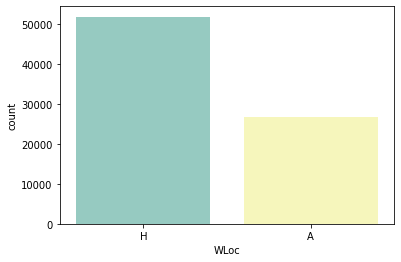

In [ ]:
sns.countplot (x="WLoc",data =capstonem,palette="Set3")

In [ ]:
capstonem['WLoc'].value_counts() # Number of games in winning location

H    51825
A    26759
Name: WLoc, dtype: int64

In [ ]:
home = capstonem['WLoc'].value_counts()[0] # first value of the result above
away = capstonem['WLoc'].value_counts()[1] # second value of the result above
total = home+ away # total count of matches
perc_away=away/ total # converting to float to get a float result
perc_home=home/ total
print("Percent of home: {}".format(perc_home)) 
print("Percent of away: {}".format(perc_away))
 

Percent of home: 0.6594853914282806
Percent of away: 0.34051460857171945


##Data Reprocessing for Machine Learning


This will be done in three steps:

1.   The dataframe is rearranged by splitting the losing team stats from the winning team stats. The losing team statistics will then be merged to the winning team in a row wise manner.
2.   The dataframe is rearranged by splitting the winning team stats from the losing team stats. The winning team statistics is dropped from the major dataframe capstonem The winning team statistics will then be merged to the losing team in a row wise manner.
3. The winning team dataframe and losing team dataframe are now renamed so that the names of both columns are identical and can thus be easily merged together


In [ ]:
#Step 1
capstoneloss=capstonem.drop(columns=["LLoc","NumOT",	"WTeamID"	,"WScore",	"WFGM",	"WFGA",	"WFGM3",	"WFGA3",	"WFTM",	"WFTA",	"WOR",	"WDR",	"WAst",	"WTO",	"WStl",	"WBlk",	"WPF"])

capstoneloss['LResults'] = ["L"]*len(capstoneloss) # Creating a location for the losing team, since data only comes with location of winning team
capstoneloss.head(5)

Season  DayNum             LTeamID  LScore  ... LStl  LBlk  LPF  LResults
0    2003      11  eastern-washington      55  ...    4     3   25         L
1    2003      12   purdue fort wayne      62  ...   10     4   28         L
2    2003      12   northern-illinois      56  ...    1     3   18         L
3    2003      13        ut-arlington      50  ...    7     3   15         L
4    2003      13             belmont      48  ...   10     0   17         L

[5 rows x 19 columns]

In [ ]:
#Step 2
capstonewin=capstonem.drop(columns=["LLoc","NumOT",	"LTeamID"	,"LScore",	"LFGM",	"LFGA",	"LFGM3",	"LFGA3",	"LFTM",	"LFTA",	"LOR",	"LDR",	"LAst",	"LTO",	"LStl",	"LBlk",	"LPF"])

capstonewin['WResults'] = ["W"]*len(capstonewin) # Creating a winning team column W
capstonewin.head(5)

Season  DayNum         WTeamID  WScore WLoc  ...  WTO  WStl  WBlk  WPF  WResults
0    2003      11       wisconsin      81    H  ...    9     9     3   18         W
1    2003      12  colorado-state      80    H  ...   17    11     1   25         W
2    2003      12       wisconsin      84    H  ...    6    12     0   13         W
3    2003      13       creighton     106    H  ...   11    10     6   16         W
4    2003      13      notre-dame      76    H  ...   13    14    19   13         W

[5 rows x 19 columns]

In [ ]:
#Step 3
capstonewin=capstonewin.rename(columns={"WTeamID":"TeamID",	"WScore":"Score",	"NumOT":"OT", "WFGM":"FGM",	"WFGA":	"FGA",	"WFGA3":"FGA3",	"WFTM":"FTM",	"WFTA":"FTA",	"WOR":"OR",	"WDR":"DR",	"WAst":"Ast"	,"WTO":"TO"	,"WStl":"Stl"	,"WBlk":"Blk", "WPF":"PF","WFGM3":"FGM3","WResults":"Results"})
capstoneloss=capstoneloss.rename(columns={"LTeamID":"TeamID",	"LScore":"Score",	"NumOT":"OT", "LFGM":"FGM",	"LFGM3":"FGM3","LFGA":	"FGA",	"LFGA3":"FGA3",	"LFTM":"FTM",	"LFTA":"FTA",	"LOR":"OR",	"LDR":"DR",	"LAst":"Ast"	,"LTO":"TO"	,"LStl":"Stl"	,"LBlk":"Blk", "LPF":"PF","LResults":"Results","Loc":"WLoc"})
res4=pd.concat([capstonewin, capstoneloss]) # Merging of the win and loss dataframes in a row-wise manner

res4.reset_index(inplace=True,drop=True)
res4 # New dataframe is now called res4

Season  DayNum          TeamID  Score WLoc  ...  TO  Stl  Blk  PF  Results
0         2003      11       wisconsin     81    H  ...   9    9    3  18        W
1         2003      12  colorado-state     80    H  ...  17   11    1  25        W
2         2003      12       wisconsin     84    H  ...   6   12    0  13        W
3         2003      13       creighton    106    H  ...  11   10    6  16        W
4         2003      13      notre-dame     76    H  ...  13   14   19  13        W
...        ...     ...             ...    ...  ...  ...  ..  ...  ...  ..      ...
157163    2019     130             ucf     55    H  ...  16    6    6  21        L
157164    2019     131         memphis     58    A  ...   9    5    5  21        L
157165    2019     131            umbc     49    H  ...  13    6    4  19        L
157166    2019     131       princeton     77    H  ...  10    4    1  17        L
157167    2019     132         harvard     85    H  ...   9    1    2  22        L

[157168 rows x 19 columns]

In [ ]:
res4['WLoc'].value_counts() # Dataframe values. As we can see, the number of rows is now doubled because we have separated the winning and losing columns into separate rows


H    103650
A     53518
Name: WLoc, dtype: int64

## Create a unique identifier for the dataframe after merging the columns

The unique identifier is a merger of the season being played, and the days of the season. Since the original dataframe only had a winning location, a new column  was created to have the location of winning and losing matches played. This new column is called "Loc""


In [ ]:
res4["DayNum"]=res4["DayNum"].astype(str) #Converting Day Num to string, so that it can be concatenated
type(res4.loc[5,"DayNum"])
res4['DayNum'] = ['0' + val if len(val) < 3 else val for val in res4['DayNum']] # Assigning a zero for daynum, so that it counts in an orderly fashion
res4['identifier'] = [str(res4.loc[i,'Season']) + '_' + str(res4.loc[i,'DayNum']) for i in range(0,len(res4))] # concatenating season and day number
res4

Season DayNum          TeamID  Score  ... Blk  PF  Results  identifier
0         2003    011       wisconsin     81  ...   3  18        W    2003_011
1         2003    012  colorado-state     80  ...   1  25        W    2003_012
2         2003    012       wisconsin     84  ...   0  13        W    2003_012
3         2003    013       creighton    106  ...   6  16        W    2003_013
4         2003    013      notre-dame     76  ...  19  13        W    2003_013
...        ...    ...             ...    ...  ...  ..  ..      ...         ...
157163    2019    130             ucf     55  ...   6  21        L    2019_130
157164    2019    131         memphis     58  ...   5  21        L    2019_131
157165    2019    131            umbc     49  ...   4  19        L    2019_131
157166    2019    131       princeton     77  ...   1  17        L    2019_131
157167    2019    132         harvard     85  ...   2  22        L    2019_132

[157168 rows x 20 columns]

In [ ]:
my_dict = {('H','W'):'H',('H','L'):'A',('A','W'):'A',('A','L'):'H'} 
res4['Loc'] = [my_dict[(res4['WLoc'][i],res4['Results'][i])] for i in range(0,len(res4))]  # creating a dictionary that creates a location for winning, losing and away and home team. Rather than only winning location
res4

Season DayNum          TeamID  Score  ...  PF  Results  identifier  Loc
0         2003    011       wisconsin     81  ...  18        W    2003_011    H
1         2003    012  colorado-state     80  ...  25        W    2003_012    H
2         2003    012       wisconsin     84  ...  13        W    2003_012    H
3         2003    013       creighton    106  ...  16        W    2003_013    H
4         2003    013      notre-dame     76  ...  13        W    2003_013    H
...        ...    ...             ...    ...  ...  ..      ...         ...  ...
157163    2019    130             ucf     55  ...  21        L    2019_130    A
157164    2019    131         memphis     58  ...  21        L    2019_131    H
157165    2019    131            umbc     49  ...  19        L    2019_131    A
157166    2019    131       princeton     77  ...  17        L    2019_131    A
157167    2019    132         harvard     85  ...  22        L    2019_132    A

[157168 rows x 21 columns]

In [ ]:
res4=res4.drop(columns=["WLoc"])	# drop winning location since location column has been created

**Creating field goal percentage, Free throw percentage, and three point percentage**

In [ ]:
res4['FGM3Rat'] = (round((res4['FGM3']/(res4['FGA3'])), 2))
res4['FGMRat'] = (round((res4['FGM']/(res4['FGA'])), 2))
res4['FTMRat'] = (round((res4['FTM']/(res4['FTA'])), 2))
res4.replace(np.nan, 0, inplace=True)

In [ ]:
res4

Season DayNum          TeamID  Score  ...  Loc  FGM3Rat  FGMRat  FTMRat
0         2003    011       wisconsin     81  ...    H     0.50    0.46    0.85
1         2003    012  colorado-state     80  ...    H     0.25    0.42    0.82
2         2003    012       wisconsin     84  ...    H     0.29    0.48    0.79
3         2003    013       creighton    106  ...    H     0.60    0.59    0.69
4         2003    013      notre-dame     76  ...    H     0.43    0.45    0.70
...        ...    ...             ...    ...  ...  ...      ...     ...     ...
157163    2019    130             ucf     55  ...    A     0.30    0.36    0.58
157164    2019    131         memphis     58  ...    H     0.17    0.24    0.85
157165    2019    131            umbc     49  ...    A     0.31    0.34    0.79
157166    2019    131       princeton     77  ...    A     0.25    0.45    0.75
157167    2019    132         harvard     85  ...    A     0.31    0.45    0.79

[157168 rows x 23 columns]

In [ ]:
# Drop FGM3 FGA3, FGM and FGA since we now have the percentage of goals attempted
res4 =res4.drop(columns=["FGM","FGA","FGM3","FGA3","FTM","FTA"])


For the remainder of the analysis, the dataframe is split into two sets, the 2003- 2018 seasons for training, and the final season 2019 for testing.

Converting Win and Losses to 0 and 1 for  logistic regression calculations. Where Loss is 0 and win is 1



In [ ]:
res4['Results'] = [1 if val == 'W' else 0 for val in res4['Results']] # converting 
res4["Loc"] = [1 if val == 'H' else  0 for val in res4['Loc']]

In [ ]:
res4_2003_2018 = res4[res4["Season"] < 2019] # Collecting data for 2003 to 2018 season to be used for training data
res4_2019 = res4[res4["Season"] > 2018] # Collecting data for 2019 season to be used for testing data

In [ ]:
res4_2019

Season DayNum           TeamID  Score  ...  Loc  FGM3Rat  FGMRat  FTMRat
73730     2019     01          alabama     82  ...    1     0.38    0.49    0.68
73731     2019     01    arizona-state    102  ...    1     0.38    0.42    0.59
73732     2019     01  army-west-point     73  ...    1     0.30    0.43    0.69
73733     2019     01           auburn    101  ...    1     0.47    0.51    0.50
73734     2019     01       ball-state     86  ...    1     0.37    0.49    0.75
...        ...    ...              ...    ...  ...  ...      ...     ...     ...
157163    2019    130              ucf     55  ...    0     0.30    0.36    0.58
157164    2019    131          memphis     58  ...    1     0.17    0.24    0.85
157165    2019    131             umbc     49  ...    0     0.31    0.34    0.79
157166    2019    131        princeton     77  ...    0     0.25    0.45    0.75
157167    2019    132          harvard     85  ...    0     0.31    0.45    0.79

[9708 rows x 17 columns]

##Data frame after two day moving average calculation##

To model a given game, an aggregation of these statistics for prior games are computed, for both the home and away teams.The lagging period used for the prior game statistics to model a game is two games. This lagged aggregation method is used to avoid “leaking” information into the model that belongs to “the future”.



In [ ]:
my_dict={} #A dictionary is created to sort teams in seasons. The teams were sorted in terms of the unique identifier created.
for team in res4_2003_2018["TeamID"].unique():
   data = res4_2003_2018[res4_2003_2018['TeamID'] == team ]
   data.sort_values("identifier",inplace=True) # Sort the teams per season in terms of the identifier created.
   my_dict[team] = [data.drop(columns=["Results","Loc"])] # Dropping the dependent variable
   my_dict[team].append(data[["Results","Loc"]])

   my_dict[team].append(my_dict[team][0].rolling(2).mean().shift()) # Rolling average on the first two matches per team in a season

   final_table = pd.concat([my_dict[team][2],my_dict[team][1]],axis=1)
   my_dict[team].append(final_table)

In [ ]:
 #my_dict[team] = data.drop(columns=["Results","Loc"])
 my_dict["duke"] [2]
 

Season  Score    OR    DR   Ast  ...  Blk    PF  FGM3Rat  FGMRat  FTMRat
92         NaN    NaN   NaN   NaN   NaN  ...  NaN   NaN      NaN     NaN     NaN
163        NaN    NaN   NaN   NaN   NaN  ...  NaN   NaN      NaN     NaN     NaN
562     2003.0   98.0  17.5  29.0  18.0  ...  8.0  16.5    0.335   0.440   0.715
1187    2003.0   88.0  16.0  26.5  15.5  ...  7.5  21.5    0.245   0.465   0.690
1310    2003.0   83.0  12.0  23.0  15.0  ...  5.0  22.5    0.355   0.535   0.635
...        ...    ...   ...   ...   ...  ...  ...   ...      ...     ...     ...
73122   2018.0   77.0  12.5  27.5  16.0  ...  5.5  12.5    0.445   0.470   0.755
73194   2018.0   70.0   9.5  27.0  11.5  ...  5.0  10.0    0.455   0.445   0.775
73351   2018.0   74.0  10.0  30.5  11.5  ...  5.5  12.5    0.405   0.435   0.895
152087  2018.0   71.0  10.0  30.5  16.0  ...  4.0  10.5    0.230   0.450   0.910
73637   2018.0   61.5  10.5  26.5  14.5  ...  3.0  13.5    0.200   0.415   0.805

[419 rows x 12 columns]

In [ ]:
my_dict["duke"] [2].head(10)

Season  Score    OR    DR   Ast  ...  Blk    PF  FGM3Rat  FGMRat  FTMRat
92        NaN    NaN   NaN   NaN   NaN  ...  NaN   NaN      NaN     NaN     NaN
163       NaN    NaN   NaN   NaN   NaN  ...  NaN   NaN      NaN     NaN     NaN
562    2003.0   98.0  17.5  29.0  18.0  ...  8.0  16.5    0.335   0.440   0.715
1187   2003.0   88.0  16.0  26.5  15.5  ...  7.5  21.5    0.245   0.465   0.690
1310   2003.0   83.0  12.0  23.0  15.0  ...  5.0  22.5    0.355   0.535   0.635
1478   2003.0   85.5  11.0  26.5  17.5  ...  8.0  22.0    0.435   0.490   0.695
1562   2003.0   87.5  12.0  24.5  17.5  ...  7.0  24.5    0.405   0.455   0.755
1795   2003.0   91.0  11.0  25.5  16.0  ...  4.5  25.0    0.395   0.520   0.665
1877   2003.0   83.5  10.0  28.0  16.0  ...  6.0  20.5    0.405   0.495   0.615
80606  2003.0   89.0   7.5  23.5  17.5  ...  5.5  22.0    0.550   0.485   0.795

[10 rows x 12 columns]

In [ ]:

full_table = pd.concat([my_dict[team][3] for team in res4_2003_2018['TeamID'].unique()])
full_table


Season  Score    OR    DR   Ast  ...  FGM3Rat  FGMRat  FTMRat  Results  Loc
0          NaN    NaN   NaN   NaN   NaN  ...      NaN     NaN     NaN        1    1
2          NaN    NaN   NaN   NaN   NaN  ...      NaN     NaN     NaN        1    1
123     2003.0   82.5  13.0  23.0  11.5  ...    0.395   0.470   0.820        1    1
360     2003.0   83.5  13.5  26.5  13.0  ...    0.415   0.465   0.800        1    0
79088   2003.0   76.0  13.0  27.5  12.0  ...    0.395   0.435   0.790        0    1
...        ...    ...   ...   ...   ...  ...      ...     ...     ...      ...  ...
151662  2018.0   72.5  16.0  23.0  11.5  ...    0.260   0.460   0.695        0    0
151808  2018.0   67.0  16.0  23.5  12.5  ...    0.325   0.420   0.675        0    1
151920  2018.0   60.5  12.0  22.0   8.0  ...    0.220   0.385   0.670        0    1
152137  2018.0   69.5  11.0  22.0   9.5  ...    0.190   0.450   0.565        0    0
73621   2018.0   64.0  11.5  23.0  14.5  ...    0.300   0.450   0.475        1    0

[147460 rows x 14 columns]

In [ ]:
full_table=full_table.dropna() # Dropping the first two rows of averaged data

In [ ]:

Team_total=full_table # Assigning full_table to team_total

In [ ]:
Team_total

Season  Score    OR    DR   Ast  ...  FGM3Rat  FGMRat  FTMRat  Results  Loc
123     2003.0   82.5  13.0  23.0  11.5  ...    0.395   0.470   0.820        1    1
360     2003.0   83.5  13.5  26.5  13.0  ...    0.415   0.465   0.800        1    0
79088   2003.0   76.0  13.0  27.5  12.0  ...    0.395   0.435   0.790        0    1
638     2003.0   74.5  11.0  21.0  12.5  ...    0.315   0.460   0.695        1    1
712     2003.0   85.5  13.0  24.5  16.0  ...    0.305   0.490   0.660        1    1
...        ...    ...   ...   ...   ...  ...      ...     ...     ...      ...  ...
151662  2018.0   72.5  16.0  23.0  11.5  ...    0.260   0.460   0.695        0    0
151808  2018.0   67.0  16.0  23.5  12.5  ...    0.325   0.420   0.675        0    1
151920  2018.0   60.5  12.0  22.0   8.0  ...    0.220   0.385   0.670        0    1
152137  2018.0   69.5  11.0  22.0   9.5  ...    0.190   0.450   0.565        0    0
73621   2018.0   64.0  11.5  23.0  14.5  ...    0.300   0.450   0.475        1    0

[146750 rows x 14 columns]

##Split the data into X & y##

Dataset splitting allows checking for overfit issues, by splitting data into a training set, which is used to fit our model, and a test set, which is used to confirm that the model (fitted on training data) gives a similar rate of correct predictions on a new but similar data which was not part of fitting the model.
 
In this project, the games played by a team during 2003 - 2018  was used for training/fitting the model, while the data for games played during the 2019 season was held for testing.
The data will be divided into X_test_home,y_test_home,X_train_home and y_train_home


In [ ]:
y=Team_total.Results #Dependent variable
X =Team_total.drop(["Results"], axis=1) # # Creating training data                  

In [ ]:
Test_home= res4_2019[res4_2019["Loc"]==1] #Sorting data by Home matches
X_test_home=Test_home.drop(columns=["Season","DayNum","TeamID","identifier","Results","Score","Loc"])

X_test_home

OR  DR  Ast  TO  Stl  Blk  PF  FGM3Rat  FGMRat  FTMRat
73730   16  29   17  20    3    6  24     0.38    0.49    0.68
73731   20  38   11  17    3    2  26     0.38    0.42    0.59
73732    6  22   14   6    5    1  22     0.30    0.43    0.69
73733   19  23   24  13    9    8  21     0.47    0.51    0.50
73734   16  26   14   9    7    5  18     0.37    0.49    0.75
...     ..  ..  ...  ..  ...  ...  ..      ...     ...     ...
157148  14  18    8  13    6    4  16     0.24    0.29    0.50
157151   9  21   10  11   11    6  18     0.27    0.32    0.62
157152  15  14   15  10    4    2  16     0.52    0.48    0.24
157162  11  32   12  10    2    4  23     0.18    0.32    0.69
157164  21  26    4   9    5    5  21     0.17    0.24    0.85

[4854 rows x 10 columns]

In [ ]:
y_test_home =Test_home["Results"].values # win and loss  results
y_test_home

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
X_train_home=Team_total[Team_total["Loc"]==1]

X_train_home=X_train_home.drop(columns=["Season","Score","Results","Loc"])


X_train_home

OR    DR   Ast    TO   Stl  Blk    PF  FGM3Rat  FGMRat  FTMRat
123     13.0  23.0  11.5   7.5  10.5  1.5  15.5    0.395   0.470   0.820
79088   13.0  27.5  12.0  10.0   6.0  5.0  12.5    0.395   0.435   0.790
638     11.0  21.0  12.5  10.0   8.0  3.5  15.0    0.315   0.460   0.695
712     13.0  24.5  16.0  12.5   6.0  2.5  20.0    0.305   0.490   0.660
1025    14.0  18.5  14.5  10.5  10.5  3.5  12.0    0.255   0.455   0.765
...      ...   ...   ...   ...   ...  ...   ...      ...     ...     ...
72190    9.5  23.0  15.5  15.0   8.5  2.5  21.0    0.355   0.425   0.750
151123   7.0  27.5  19.0  17.5   5.0  4.0  24.5    0.405   0.535   0.670
72649   12.5  22.0  11.5  16.0   6.5  2.5  20.5    0.265   0.480   0.710
151808  16.0  23.5  12.5  16.0   7.0  3.5  19.5    0.325   0.420   0.675
151920  12.0  22.0   8.0  15.5   7.5  1.5  16.5    0.220   0.385   0.670

[73389 rows x 10 columns]

In [ ]:
y_train_home= Team_total[Team_total["Loc"]==1] #sorting by home matches
y_train_home=y_train_home["Results"] # Win and loss result for home matches

##Scaling the Model
Scaling is applied to the independent variables (X_train_home & X_test_home). It basically helps to normalise the data.

In [ ]:
# Scaled X :
scaler = MinMaxScaler()
scaler.fit(X_train_home)
Xn_train = scaler.transform(X_train_home)
Xn_test = scaler.transform(X_test_home)

##Construct and Tune the Model

The model has some hyperparameters we can tune for hopefully better performance. For tuning the parameters of your model, you will use a mix of cross-validation and grid search. In Logistic Regression, the most important parameter to tune is the regularization parameter C. Note that the regularization parameter is not always part of the logistic regression model.
The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection.
You will now implement some code to perform model tuning and selecting the regularization parameter $C$.
We use the following cv_score function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [ ]:
# construct the LogisticRegression model
clf = LogisticRegression()
# Fit the model on the training data.
clf.fit(Xn_train, y_train_home) 

y_predict_test = clf.predict(Xn_test)


In [ ]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(Xn_train, y_train_home)

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 31.622776601683793}
Best score is 0.6642548459792829


##Evaluating the model



In [ ]:
# use sklearn.metrics.classification_report for a more comprehensive
# performance analysis

from sklearn.metrics import classification_report
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

y_predict_training = clf.predict(Xn_train)
print(Xn_train.shape)


print("\n")
print(confusion_matrix(y_train_home, y_predict_training))
print("\n")

print("[Train Classification Report]")
print(classification_report(y_train_home, y_predict_training))
# Print the accuracy from the training data.
print("\n")
print("[Train] Accuracy score (y_predict_training, ytrain_home):",accuracy_score(y_predict_training, y_train_home))

(73389, 10)


[[ 2535 22432]
 [ 2181 46241]]


[Train Classification Report]
              precision    recall  f1-score   support

           0       0.54      0.10      0.17     24967
           1       0.67      0.95      0.79     48422

    accuracy                           0.66     73389
   macro avg       0.61      0.53      0.48     73389
weighted avg       0.63      0.66      0.58     73389



[Train] Accuracy score (y_predict_training, ytrain_home): 0.6646227636294267


In [ ]:


print(Xn_test.shape)


print("\n")
print(confusion_matrix(y_test_home, y_predict_test))
print("\n")

print("[Test Classification Report]")
print(classification_report(y_test_home, y_predict_test))
# Print the accuracy from the testing data.
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest_home):",accuracy_score(y_predict_test, y_test_home))


(4854, 10)


[[ 225 1488]
 [  10 3131]]


[Test Classification Report]
              precision    recall  f1-score   support

           0       0.96      0.13      0.23      1713
           1       0.68      1.00      0.81      3141

    accuracy                           0.69      4854
   macro avg       0.82      0.56      0.52      4854
weighted avg       0.78      0.69      0.60      4854



[Test] Accuracy score (y_predict_test, ytest_home): 0.6913885455294603


Since the model's test accuracy (0.68) is pretty close to the training accuracy( 0.66), then one says that there is no "variance" between the training accuracy and the test accuracy. This is an indication that the model will "generalize well", which means that the model will be well-behaved when new data is presented to it.

##Extended Modeling: Feature Selection by Recursive Feature Elimination (RFE)	

**Reference for Feature Selection**
https://scikit-learn.org/stable/modules/feature_selection.html

In [ ]:

model_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
sel_rfe_logistic = RFE(estimator=model_logistic, n_features_to_select=5, step=1) # Selecting top five features from RFE 
X_train_home_rfe_logistic = sel_rfe_logistic.fit_transform(X_train_home,y_train_home)

In [ ]:
# All the features with the value 1 are the most important features 
selected_rfe_features=pd.DataFrame({'Feature':list(X_train_home.columns),'Ranking':sel_rfe_logistic.ranking_})
selected_rfe_features.sort_values(by="Ranking")

Feature  Ranking
0       OR        1
5      Blk        1
7  FGM3Rat        1
8   FGMRat        1
9   FTMRat        1
3       TO        2
4      Stl        3
1       DR        4
2      Ast        5
6       PF        6

In [ ]:
 #we use the result from the feature selection based on the RFE test

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg =LogisticRegression()
rfe=RFE(logreg,5) # Picking the top 5 features for calibration
rfe=rfe.fit(Xn_train,y_train_home)
print(X_train_home_rfe_logistic.shape)
print(Xn_test.shape)


(73389, 5)
(4854, 10)


In [ ]:
print(Xn_test.shape)
y_predict_test = rfe.predict(Xn_test)
print("[Confusion Matrix for Test Data using RFE]")
print(confusion_matrix(y_test_home,y_predict_test))

print("\n")
print("[Test Classification Report]")
print(classification_report(y_test_home, y_predict_test))


y_predict_training = rfe.predict(Xn_train)

# Print the accuracy from the testing data.
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest_home):",accuracy_score(y_predict_test, y_test_home))


(4854, 10)
[Confusion Matrix for Test Data using RFE]
[[ 247 1466]
 [  15 3126]]


[Test Classification Report]
              precision    recall  f1-score   support

           0       0.94      0.14      0.25      1713
           1       0.68      1.00      0.81      3141

    accuracy                           0.69      4854
   macro avg       0.81      0.57      0.53      4854
weighted avg       0.77      0.69      0.61      4854



[Test] Accuracy score (y_predict_test, ytest_home): 0.6948908117016893


#Conclusions#
Logistic Regression was used to build models to predict the outcome of  matches in NCAA basketball games for 351 different teams. More specifically, the models estimate the probability of a home team winning a match. Data was partitioned into training and test for model validation. The training set included data from 2003-2018, and the test data was for the 2019 season. A performance matrix was generated both for the training and test data.
The global accuracy prediction for the test and training data was sixty nine percent for model prediction. However,  for the performance matrix for both the training and test data,  a low recall value was obtained for the minority class (away wins) versus the recall value obtained for the majority class (home wins).
This implies that the model is good when predicting when the home team is going to win, and not good at predicting when an away team is going to win
 
From the perspective of improving the global accuracy of the Logistic Regression models using RFE, the most important features are: field goal percentage made, field throw percentage made, free throw percentage made, blocks and offensive rebounds. This does not mean that these features are the most important ones with respect to a home team winning a game. 
 
In order to determine which features contribute the most to the home teams winning a game, through a Logistic Regression (LGR) model, would be to analyze the coefficients of the LGR models.
